# Brain-Machine Interface Spike Sorting with PCA

### EE 16B: Designing Information Devices and Systems II, Spring 2018

## Table of Contents

* [Introduction](#introduction)
* [Task 1: Two Neuron Spike Sorting](#task1)
* [Task 2: Three Neuron Spike Sorting](#task2)
* [Task 3: Determining Neurons](#task3)

<a id='introduction'></a>
# Introduction



For SIXT33N (your robot car), you will need to use SVD and PCA to classify your sound input (either words or music). This exercise will help make sure you are prepared for the next two labs. Make sure you complete this problem before your lab next week.

Brain-Machine interfaces (BMIs) are a way for a brain to communicate to an external device. They're often used for research, mapping, assisting or repairing human cognitive or sensory-motor function. 

Data was collected that shows spike timestamps of simulated brain waves of a subject whose arm is pointing in certain directions over time. These spike timestamps are gathered from electrodes, but the electrodes could be recording more than 1 neuron at the same time. To make predictions based on neuron firing rates, we need to be able to distinguish spikes that come from different neurons. 

Luckily for us, it is highly unlikely for two neurons next to each other to fire at precisely the same time, so in practice the "average" potential waveform looks like a sum of spike waveforms from different neurons. Additionally, each neuron has its own spike "signature" unique to that neuron. This is due to the physical characteristics of neurons, such as their shape and structure. It is impossible to know beforehand how many neurons an electrode measures or what each neuron's spike waveform looks like, so we must first separate the spikes from the different neurons near the electrode.

The goal of this problem is to see how we can use PCA and clustering to decide which neuron fired. We will first look at a case where there are only two neurons, then a case where there are three neurons. We provide both training and test sets with two and three neurons. The neurons have also been presorted using a professional software, so we can check our model against presorted data.

<a id='task1'></a>
## <span style="color:blue">Task 1: Two Neuron Spike Sorting</span>

A spike occurs when the potential passes a certain threshold in a neuron. In our data set, each recorded waveform contains `N=32` samples taken at a sampling frequency of 40kHz, which means the time difference between each consecutive sample is 800$\mu$s. We can represent each vector exactly with any 32-dimensional basis, as long as the vectors making up the basis are linearly independent. However, we want to compute a minimal set of basis vectors that brings out the features of the data using Principal Component Analysis (PCA).

Import the data sets and see the average waveform for each presorted neuron by running the following cell.

In [1]:
%matplotlib inline
import numpy as np
import scipy.io
import scipy.cluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load data
presorted = {k: v for k, v in scipy.io.loadmat('spike_waveforms').items() \
             if k in ('sig118a_wf', 'sig118b_wf', 'sig118c_wf')}
presorted = [presorted['sig118b_wf'], presorted['sig118c_wf'], presorted['sig118a_wf']]

In [2]:
def _make_training_set(data):
    """ Separate data set into 2 sets. 
    1/6 of the dataset is training set and the rest is test set
    Parameter:
        data: waveform data (width = number of samples per spike)
    """
    n = data.shape[0]
    idx_training = np.random.choice(n, n//6, replace=False)
    training_set = data[idx_training]
    test_set = [data[i] for i in range(n) if n not in idx_training]
    return training_set, test_set

# Create training and testing dataset
two_neurons_training, two_neurons_test = _make_training_set(np.concatenate(presorted[:2]))
three_neurons_training, three_neurons_test = _make_training_set(np.concatenate(presorted))

Let's first see what the spikes look like. Below, we first plot 100 random spikes. Then, we plot the distinct shapes of the 3 neurons, taking the average over all of the samples gathered from that neuron based on the presorted data. The goal of this lab is to classify each of the lines in the first plot as one of the neurons in the second plot.

Text(0.5, 1.0, 'Averaged presorted 3 neuron spikes')

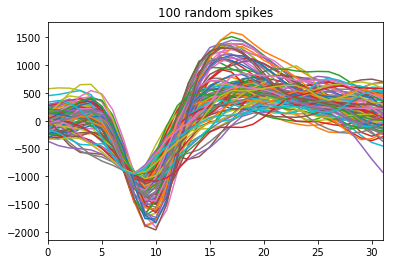

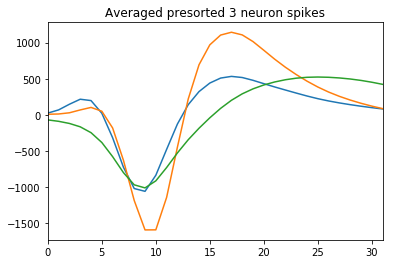

In [3]:
# Plot 100 random spikes
for waveforms in three_neurons_training[:100]:
    plt.plot(waveforms)
plt.xlim((0,31))
plt.title('100 random spikes')

# Plot the 3 spike shapes based on the presorted data
plt.figure()
for waveforms in presorted:
    plt.plot(np.mean(waveforms, axis=0))
plt.xlim((0,31))
plt.title('Averaged presorted 3 neuron spikes')

We can represent each spike in a lower dimensional space using PCA. In your implementation of PCA, you will decide how to choose these components.

**<font color="red">Using PCA, what will be the principal components if we use data from an electrode that measures 3 neurons?** Describe a special property of the first two principal components.

The principle components will be the directions that maximize the differences between the three neurons. The first two components will show more varience than the third one. All three components are orthogonal, so they can form a basis for our data.

You will be using <a href="http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html">np.linalg.svd</a> in your PCA function. Read the documentation for this function to figure out how to choose the principal components used as the basis for the lower dimensional space. (Note: in the docs, `a.H` means the congugate transpose of a).

**<font color="red">What does SVD return and how will you use those results?**

U, S, and V. The rows of V will contain the components that we want to use as a basis.

Complete the functions below to implement PCA training and classifying. Don't forget that you will need to offset the data by the mean!

In [4]:
def PCA_train(training_set, n_components):
    """ Use np.linalg.svd to perform PCA
    Parameters:
        training_set: the data set to perform PCA on (MxN)
            M rows: number of neuron spikes
            N=32 columns: sample length of each spike 
        n_components: the dimensionality of the basis to return (i.e. number of neurons)
    Returns: 
        The n_components most significant principal components
        The mean of each column of the original data
    Hint: Subtract the mean of the data first so the average of each column is 0. The axis 
        parameter of np.mean is helpful here.
    """    
    # YOUR CODE HERE #
    # SOLN START #
    mean = np.mean(training_set, axis=0)
    training_set = training_set - mean
    U, S, V = np.linalg.svd(training_set)
    basis_components = V[:n_components]     # the larger components are given first
    # SOLN END #
    return basis_components, mean

def PCA_classify(data, new_basis, mean):
    """ Project the data set, adjusted by the mean, into the new basis vectors
    Parameters:
        data: data to project (MxN)
            M rows: number of neuron spikes
            N=32 columns: sample length of each spike 
        new_basis: new bases (KxN)
            K: number of basis vectors
        mean: mean of each timestamp from PCA (list of length N)
    Returns: 
        Data projected onto new_basis (MxK)
    Hint: Don't forget to adjust the data with the PCA training mean!
    """
    # YOUR CODE HERE #
    # SOLN START #
    return np.dot(data-mean, new_basis.T)
    # SOLN END #

Now let's call `PCA_train` on `two_neurons_training` and plot the 2 principal components. Note that since the dataset is randomized, you might get different plots every time you run the second code cell of this notebook (the `_make_training_set` function).

**Note that these components have no real 'physical' relationship to the shape of the neuron plots.**

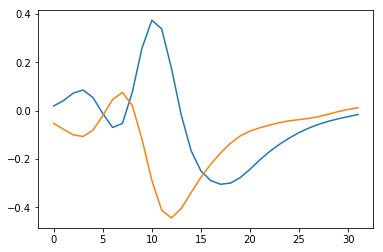

In [5]:
# Perform PCA and plot the first 2 principal components.

# YOUR CODE HERE
# BEGIN SOLN
two_new_basis, two_mean = PCA_train(two_neurons_training, 2)
# END SOLN

# Plot the basis components
for comp in two_new_basis:
    plt.plot(comp)

Now, classify `two_neurons_test` using that model and produce a scatter plot in the new basis. We will also try classifying the presorted data containing 2 neurons so we can see how the model behaves on the 2 neurons.

(19357, 2)
[  623.0182936   1276.84042708  1279.09748818 ... -1340.65984002
  -947.28418365  -691.75624159] [  424.31611739  -304.40265064   662.50107144 ...   176.05614034
 -1067.83954044  -976.6156671 ]


Text(0.5, 1.0, 'Presorted data')

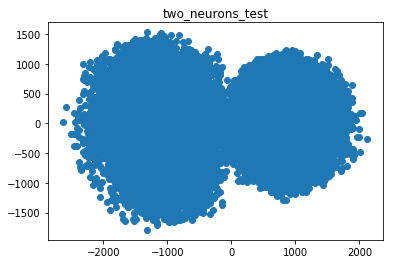

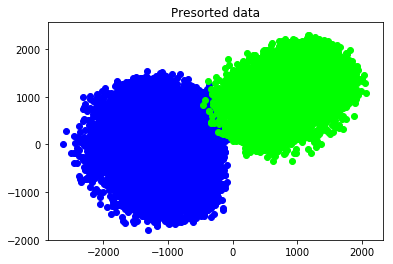

In [14]:
# Project the test data two_neurons_test to the basis you found earlier

# YOUR CODE HERE #
# SOLN START #
two_classified = PCA_classify(two_neurons_test, two_new_basis, two_mean)
print(np.shape(two_classified))
print(*two_classified.T)
# SOLN END #

# Plot the classified neurons
plt.figure()
plt.scatter(*two_classified.T)
plt.title('two_neurons_test')

# Project the presorted data and plot it
plt.figure()
presorted_two_classified = [PCA_classify(spikes, two_new_basis, two_mean) for spikes in presorted[1:]]
colors = ['#0000ff', '#00ff00']
for dat, color in zip(presorted_two_classified, colors):
    plt.scatter(*dat.T, c=color)
plt.title('Presorted data')

Note that the first principal component separates the two neurons in the $x$-axis. **Thus, technically we only need 1 principal component to separate the two neurons.** This is because the algorithm maximizes the square of the dot product of each signal with the principal component, which results in a large positive dot product with 1 neuron and a large negative dot product with the other.

<a id='task2'></a>
## <span style="color:blue">Task 2: Three Neuron Spike Sorting</span>

Now call `PCA_train` on `three_neurons_training` and plot the 3 principal components.

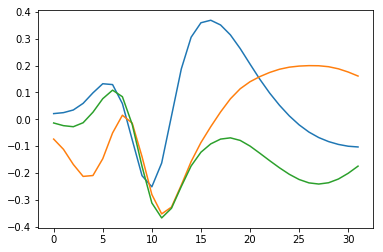

In [7]:
# Repeat training with three neuron data, producing 3 principal components

# YOUR CODE HERE
# BEGIN SOLN
three_new_basis, three_mean = PCA_train(three_neurons_training, 3)
# END SOLN

# Plot the resulting basis
for comp in three_new_basis:
    plt.plot(comp)

Do the same classification process as the 2 neuron data, but now with the 3 neuron data. Compare your model's behavoir with that of the presorted data. The `plot_3D` function below will be useful to view the results.

[array([[  -22.69030159,  -619.08271637,   675.68554676],
       [ -479.66489012, -1064.40536593,  -294.17919738],
       [ -598.47278766,  -940.34838978,   821.01394855],
       ...,
       [ -223.31088482,  -125.86685151,   225.9834141 ],
       [  366.4463476 , -1528.92352816,   260.31211626],
       [ -144.79029717,  -856.16438605,    20.90238774]]), array([[1682.38767648,  856.5617108 ,  184.79499436],
       [1279.67277754,   17.11137416, -563.27101654],
       [1447.50566541, -698.6299357 ,    2.35383895],
       ...,
       [1678.48553202,  374.64275017,  478.47280593],
       [1797.04602726, -495.51433052, -474.02814387],
       [1720.82691918, -853.70730541,  -88.99782473]]), array([[-1875.85736155,   351.50808192,  -330.14730839],
       [ -747.47737542,   563.69713349,   135.51029002],
       [-2190.12975426,   810.11417994,   572.27801705],
       ...,
       [-1224.06310605,   226.96224186,  -617.72487206],
       [ -943.61775238,   906.22225945,  -347.9658713 ],
       [

Text(0.5, 0.92, 'Presorted data projected to 3 principal components')

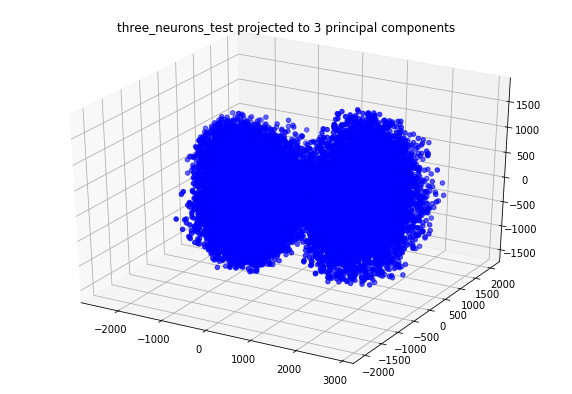

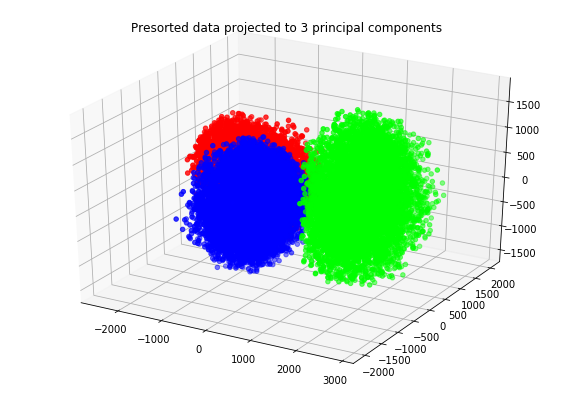

In [18]:
def plot_3D(data, view_from_top=False):
    """ Takes list of arrays (x, y, z) coordinate triples
    One array of triples per color
    """
    fig=plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['#0000ff', '#00ff00', '#ff0000']
    for dat, color in zip(data, colors):
        Axes3D.scatter(ax, *dat.T, c=color)
    if view_from_top:
        ax.view_init(elev=90.,azim=0)  # Move perspective to view from top

        
# Classify the three_neurons_test data based on the basis computed above
# YOUR CODE HERE #
# BEGIN SOLN #
three_classified = PCA_classify(three_neurons_test, three_new_basis, three_mean)

# END SOLN #


# Plot the resulting classificaiton
plot_3D([three_classified], view_from_top=False)
plt.title('three_neurons_test projected to 3 principal components')

presorted_classified = [PCA_classify(spikes, three_new_basis, three_mean) for spikes in presorted]
print(presorted_classified)
plot_3D(np.array(presorted_classified), view_from_top=False)
plt.title('Presorted data projected to 3 principal components')

**<font color="red">How many principal components do you actually need to cluster the 3 neurons?** Change the second argument to the `plot_3D` function calls above to True to view the plots "from the top" (i.e. looking down the positive z axis).

2 - we can see that the clusters are relatively similar at each Z location, so we only need to worry about their location in the x-y plane.

<a id='task3'></a>
## <span style="color:blue">Task 3: Determining Neurons</span>

Now that we have seperated the data into clusters, we can use k-means clustering to determine how many times each neuron fired. We can use this information to create a rough estimate for the average firing rate of each neuron over the time spanned by the given data.

Scipy just happens to have a function to compute k-means given clustered data, which we have conveniently formated above. First, read the documentation for the function **`scipy.cluster.vq.kmeans`** <a href="http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans.html#scipy.cluster.vq.kmeans">here</a>.

**<font color="red">Based on the documentation for `scipy.cluster.vq.kmeans`, how will we be need to adjust our approach for the 2-neuron and 3-neuron data sets?**

We will need to change the number of clusters from 2 to 3.

Now that we are familiar with how the function works, lets try to determine how many times each neuron fired in the 2-neuron data set. Start by determining the centroids of each cluster.

### **<font color="red">TWO IMPORTANT NOTES**

- **We do NOT need to whiten the data as in the Scipy documentation.**
- **K-means returns centroids in a random order.** They won't be ordered the same way each time you run k-means.

In [9]:
def find_centroids(clustered_data, num_of_clusters):
    """ Use scipy.cluster.vq.kmeans to determine centroids of clusters
    Parameters:
        clustered_data: the data projected onto the new basis
        num_of_clusters: the expected number of clusters in the data
    Returns: 
        The centroids of the clusters
    We do NOT need to whiten the data as in the Scipy documentation.
    """
    # YOUR CODE HERE #
    # SOLN START #
    return scipy.cluster.vq.kmeans(clustered_data, num_of_clusters)[0]
    # SOLN END #

Now, call **`find_centroids`** on the projected 2-neuron data.

In [10]:
# Determine the centroids in the 2-neuron data

# YOUR CODE HERE #
# SOLN START #
centroid_list = find_centroids(two_classified, 2)
# SOLN END #

# Print the centroid locations
centroid1 = centroid_list[0]
centroid2 = centroid_list[1]

print('The first centroid is at: ' + str(centroid1))
print('The second centroid is at: ' + str(centroid2))

The first centroid is at: [798.79266307  22.26961263]
The second centroid is at: [-1184.05733496   -30.24996245]


Now that we have the location of the clusters, we can determine which neuron fired for each data point. We will do this by determing the centroid closer to the data point in question

In [11]:
def which_neuron(data_point, centroid1, centroid2):
    """ Determine which centroid is closest to the data point
    Inputs:
        data_point: 1x2 array containing x/y coordinates of data point
        centroid1: 1x2 array containing x/y coordinates of centroid 1
        centroid2: 1x2 array containing x/y coordinates of centroid 1
    Returns: 
        The centroid closest to the data point
    """
    
    # YOUR CODE HERE
    # SOLN START #
    dist1 = np.linalg.norm(data_point - centroid1)
    dist2 = np.linalg.norm(data_point - centroid2)
    
    if dist1 <= dist2:
        return 1
    else:
        return 2
    # SOLN END #

Now apply this to the two_classified data set and count the number of times each neuron fired

In [12]:
# Determine how many times neuron1 and neuron2 fired in the two_classifed data

num_of_firings = np.zeros(2, dtype=np.int32)

# YOUR CODE HERE
# SOLN START #
for classified_spike in two_classified:#i in range(len(two_classified)):
    neuron_number = which_neuron(classified_spike, centroid1, centroid2)
    num_of_firings[neuron_number-1] +=1

# SOLN END #    
    
# Print the results
print('Neuron corresponding to')
print('\tcentroid 1 fired {:d} times.'.format(num_of_firings[0]))
print('\tcentroid 2 fired {:d} times.'.format(num_of_firings[1]))

Neuron corresponding to
	centroid 1 fired 11614 times.
	centroid 2 fired 7743 times.


In [13]:
correct_num_firings = [len(neur) for neur in presorted]
print('Correct counts:')
for i in range(len(correct_num_firings)):
    print('\tNeuron {:d}: {:d}'.format(i, correct_num_firings[i]))
errors = [max(num_of_firings)/len(presorted[0]) - 1,
          min(num_of_firings)/len(presorted[1]) - 1]
print('\nClassification error:\n\tNeuron 1: {:.2%}\n\tNeuron 2: {:.2%}\n'.format(*errors))

Correct counts:
	Neuron 0: 11558
	Neuron 1: 7799
	Neuron 2: 7031

Classification error:
	Neuron 1: 0.48%
	Neuron 2: -0.72%

